# Vision Transformer (ViT) Segmentation

This notebook shows how a Vision Transformer processes images for segmentation tasks. We will use our custom `ShapesDataset` to create a synthetic dataset of images with simple geometric shapes and their corresponding segmentation masks.



In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import timm
import numpy as np
import os
import json
import torch.nn.functional as F


from PIL import Image


from torch.utils.data import Dataset


torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

%config InlineBackend.figure_format = 'retina'  # For high-res images in notebooks

Using device: mps


## Step 1: Load Pre-trained ViT Model

Using `timm` library (install: `pip install timm`)

In [25]:
all_vit_models = timm.list_models('vit*')
print(f"Available ViT models: {all_vit_models}")

Available ViT models: ['vit_base_mci_224', 'vit_base_patch8_224', 'vit_base_patch14_dinov2', 'vit_base_patch14_reg4_dinov2', 'vit_base_patch16_18x2_224', 'vit_base_patch16_224', 'vit_base_patch16_224_miil', 'vit_base_patch16_384', 'vit_base_patch16_clip_224', 'vit_base_patch16_clip_384', 'vit_base_patch16_clip_quickgelu_224', 'vit_base_patch16_gap_224', 'vit_base_patch16_plus_240', 'vit_base_patch16_plus_clip_240', 'vit_base_patch16_reg4_gap_256', 'vit_base_patch16_rope_reg1_gap_256', 'vit_base_patch16_rpn_224', 'vit_base_patch16_siglip_224', 'vit_base_patch16_siglip_256', 'vit_base_patch16_siglip_384', 'vit_base_patch16_siglip_512', 'vit_base_patch16_siglip_gap_224', 'vit_base_patch16_siglip_gap_256', 'vit_base_patch16_siglip_gap_384', 'vit_base_patch16_siglip_gap_512', 'vit_base_patch16_xp_224', 'vit_base_patch32_224', 'vit_base_patch32_384', 'vit_base_patch32_clip_224', 'vit_base_patch32_clip_256', 'vit_base_patch32_clip_384', 'vit_base_patch32_clip_448', 'vit_base_patch32_clip_quic

In [26]:
model_name = 'vit_tiny_patch16_224'
model = timm.create_model(model_name, pretrained=True)
model = model.to(device)
model.eval()

print(f"Model: {model.__class__.__name__}")
print(f"Patch size: 16x16")
print(f"Number of patches: {(224//16)**2} = 196")
print(f"Embedding dim: {model.embed_dim}")
print(f"Transformer layers: {len(model.blocks)}")
print(f"Attention heads: {model.blocks[0].attn.num_heads}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Model: VisionTransformer
Patch size: 16x16
Number of patches: 196 = 196
Embedding dim: 192
Transformer layers: 12
Attention heads: 3
Number of parameters: 5717416


## Step 2: Load and Visualize shapes dataset

In [27]:
class ShapesDiskDataset(Dataset):
    def __init__(self, root="shapes224", split="train", transform=None, target_transform=None):
        self.root = root
        self.split = split
        self.transform = transform or transforms.ToTensor()
        self.target_transform = target_transform
        self.meta_path = os.path.join(root, "metadata.json")
        with open(self.meta_path, "r") as f:
            metadata = json.load(f)
        self.samples = metadata[split]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img_path = os.path.join(self.root, self.split, sample["image"])
        mask_path = os.path.join(self.root, self.split, sample["mask"])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img = self.transform(img)
        mask = torch.tensor(np.array(mask), dtype=torch.long)
        return img, mask

Train samples: 1000


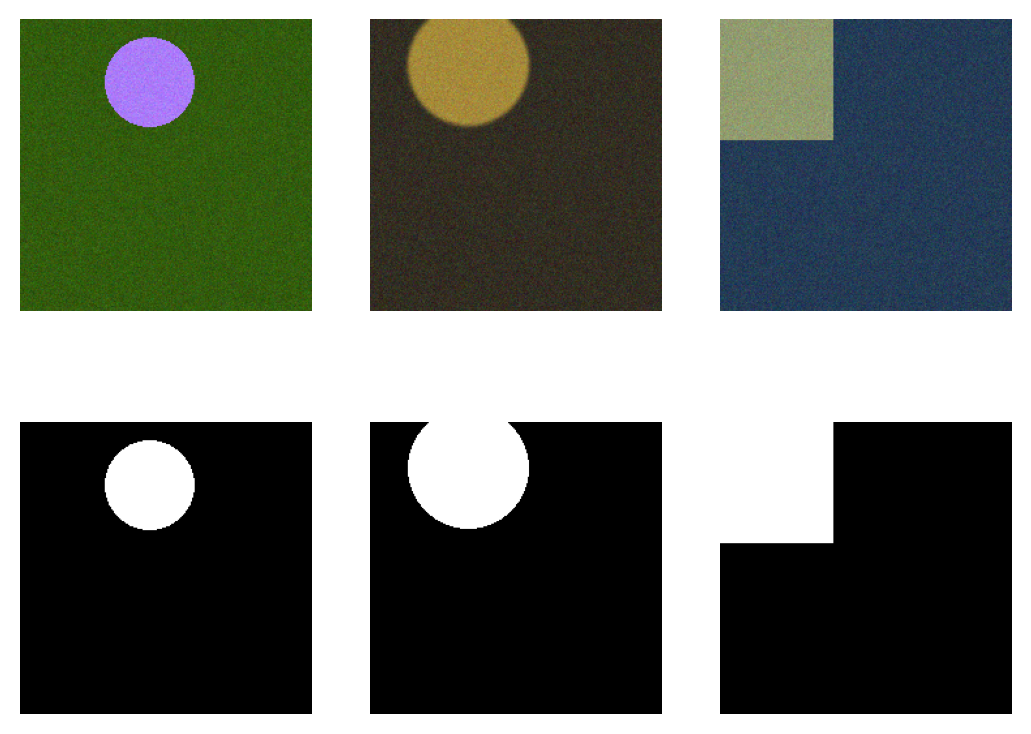

In [28]:
train_dataset = ShapesDiskDataset(root="shapes224", split="train")
print(f"Train samples: {len(train_dataset)}")

for i in range(3):
    img, mask = train_dataset[i]
    plt.subplot(2,3,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.axis('off')
    plt.subplot(2,3,i+4)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

#### Inspect model


In [29]:
print("Classifier head:", model.head)

Classifier head: Linear(in_features=192, out_features=1000, bias=True)


#### Make Changes to ViT for Segmentation

In [30]:
# Drop the classifier head
model.head = nn.Identity()
print("Modified head:", model.head)

Modified head: Identity()


In [42]:
class ViTSegmentation(nn.Module):
    def __init__(self, vit_backbone, num_classes=1):   # 1 → binary (BG/FG)
        super().__init__()
        self.vit = vit_backbone
        self.embed_dim = self.vit.embed_dim           # e.g., 192 for vit_tiny
        self.patch = self.vit.patch_embed.proj.kernel_size[0]  # 16
        self.img_size = 224
        self.grid = self.img_size // self.patch       # 14

        # light decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(self.embed_dim, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, num_classes, 1)
        )

    def forward(self, x):
        # tokens: [B, N+1, D] (CLS + 14*14 patches)
        tokens = self.vit.forward_features(x)         # timm ViT → [B, 197, D]
        patch_tok = tokens[:, 1:, :]                  # drop CLS → [B, 196, D]
        B, N, D = patch_tok.shape
        h = w = int(N ** 0.5)                         # 14
        feat = patch_tok.transpose(1, 2).reshape(B, D, h, w).contiguous()  # [B,D,14,14]
        logits = self.decoder(feat)                   # [B,C,14,14]
        logits = F.interpolate(logits, size=x.shape[-2:], mode='bilinear', align_corners=False)
        return logits                                  # [B,C,224,224]


In [43]:
seg_model = ViTSegmentation(model, num_classes=1).to(device)


#### Forward pass on dummy data

In [44]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    dummy_output = seg_model(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {dummy_output.shape}")  # [1, 1, 224, 224]


Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 1, 224, 224])


#### Forward Pass on Actual Data

In [45]:
@torch.no_grad()
def visualize_batch(model, loader, device, n=4):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs = imgs.to(device)
    print(f"Batch image shape: {imgs.shape}")
    print(f"Batch mask shape: {masks.shape}")
    logits = model(imgs)
    probs = torch.sigmoid(logits).cpu()
    preds = (probs > 0.5).float()

    imgs = imgs.cpu()
    masks = masks.unsqueeze(1).float()  # [B,1,H,W]

    plt.figure(figsize=(12, 3*n))
    for i in range(n):
        plt.subplot(n,3,3*i+1); plt.imshow(imgs[i].permute(1,2,0)); plt.title("Image"); plt.axis('off')
        plt.subplot(n,3,3*i+2); plt.imshow(masks[i,0], cmap='gray'); plt.title("GT"); plt.axis('off')
        plt.subplot(n,3,3*i+3); plt.imshow(preds[i,0], cmap='gray'); plt.title("Pred"); plt.axis('off')
    plt.tight_layout(); plt.show()



In [46]:
test_loader = DataLoader(
    ShapesDiskDataset(root="shapes224", split="test"),
    batch_size=8, shuffle=True)


Batch image shape: torch.Size([8, 3, 224, 224])
Batch mask shape: torch.Size([8, 224, 224])


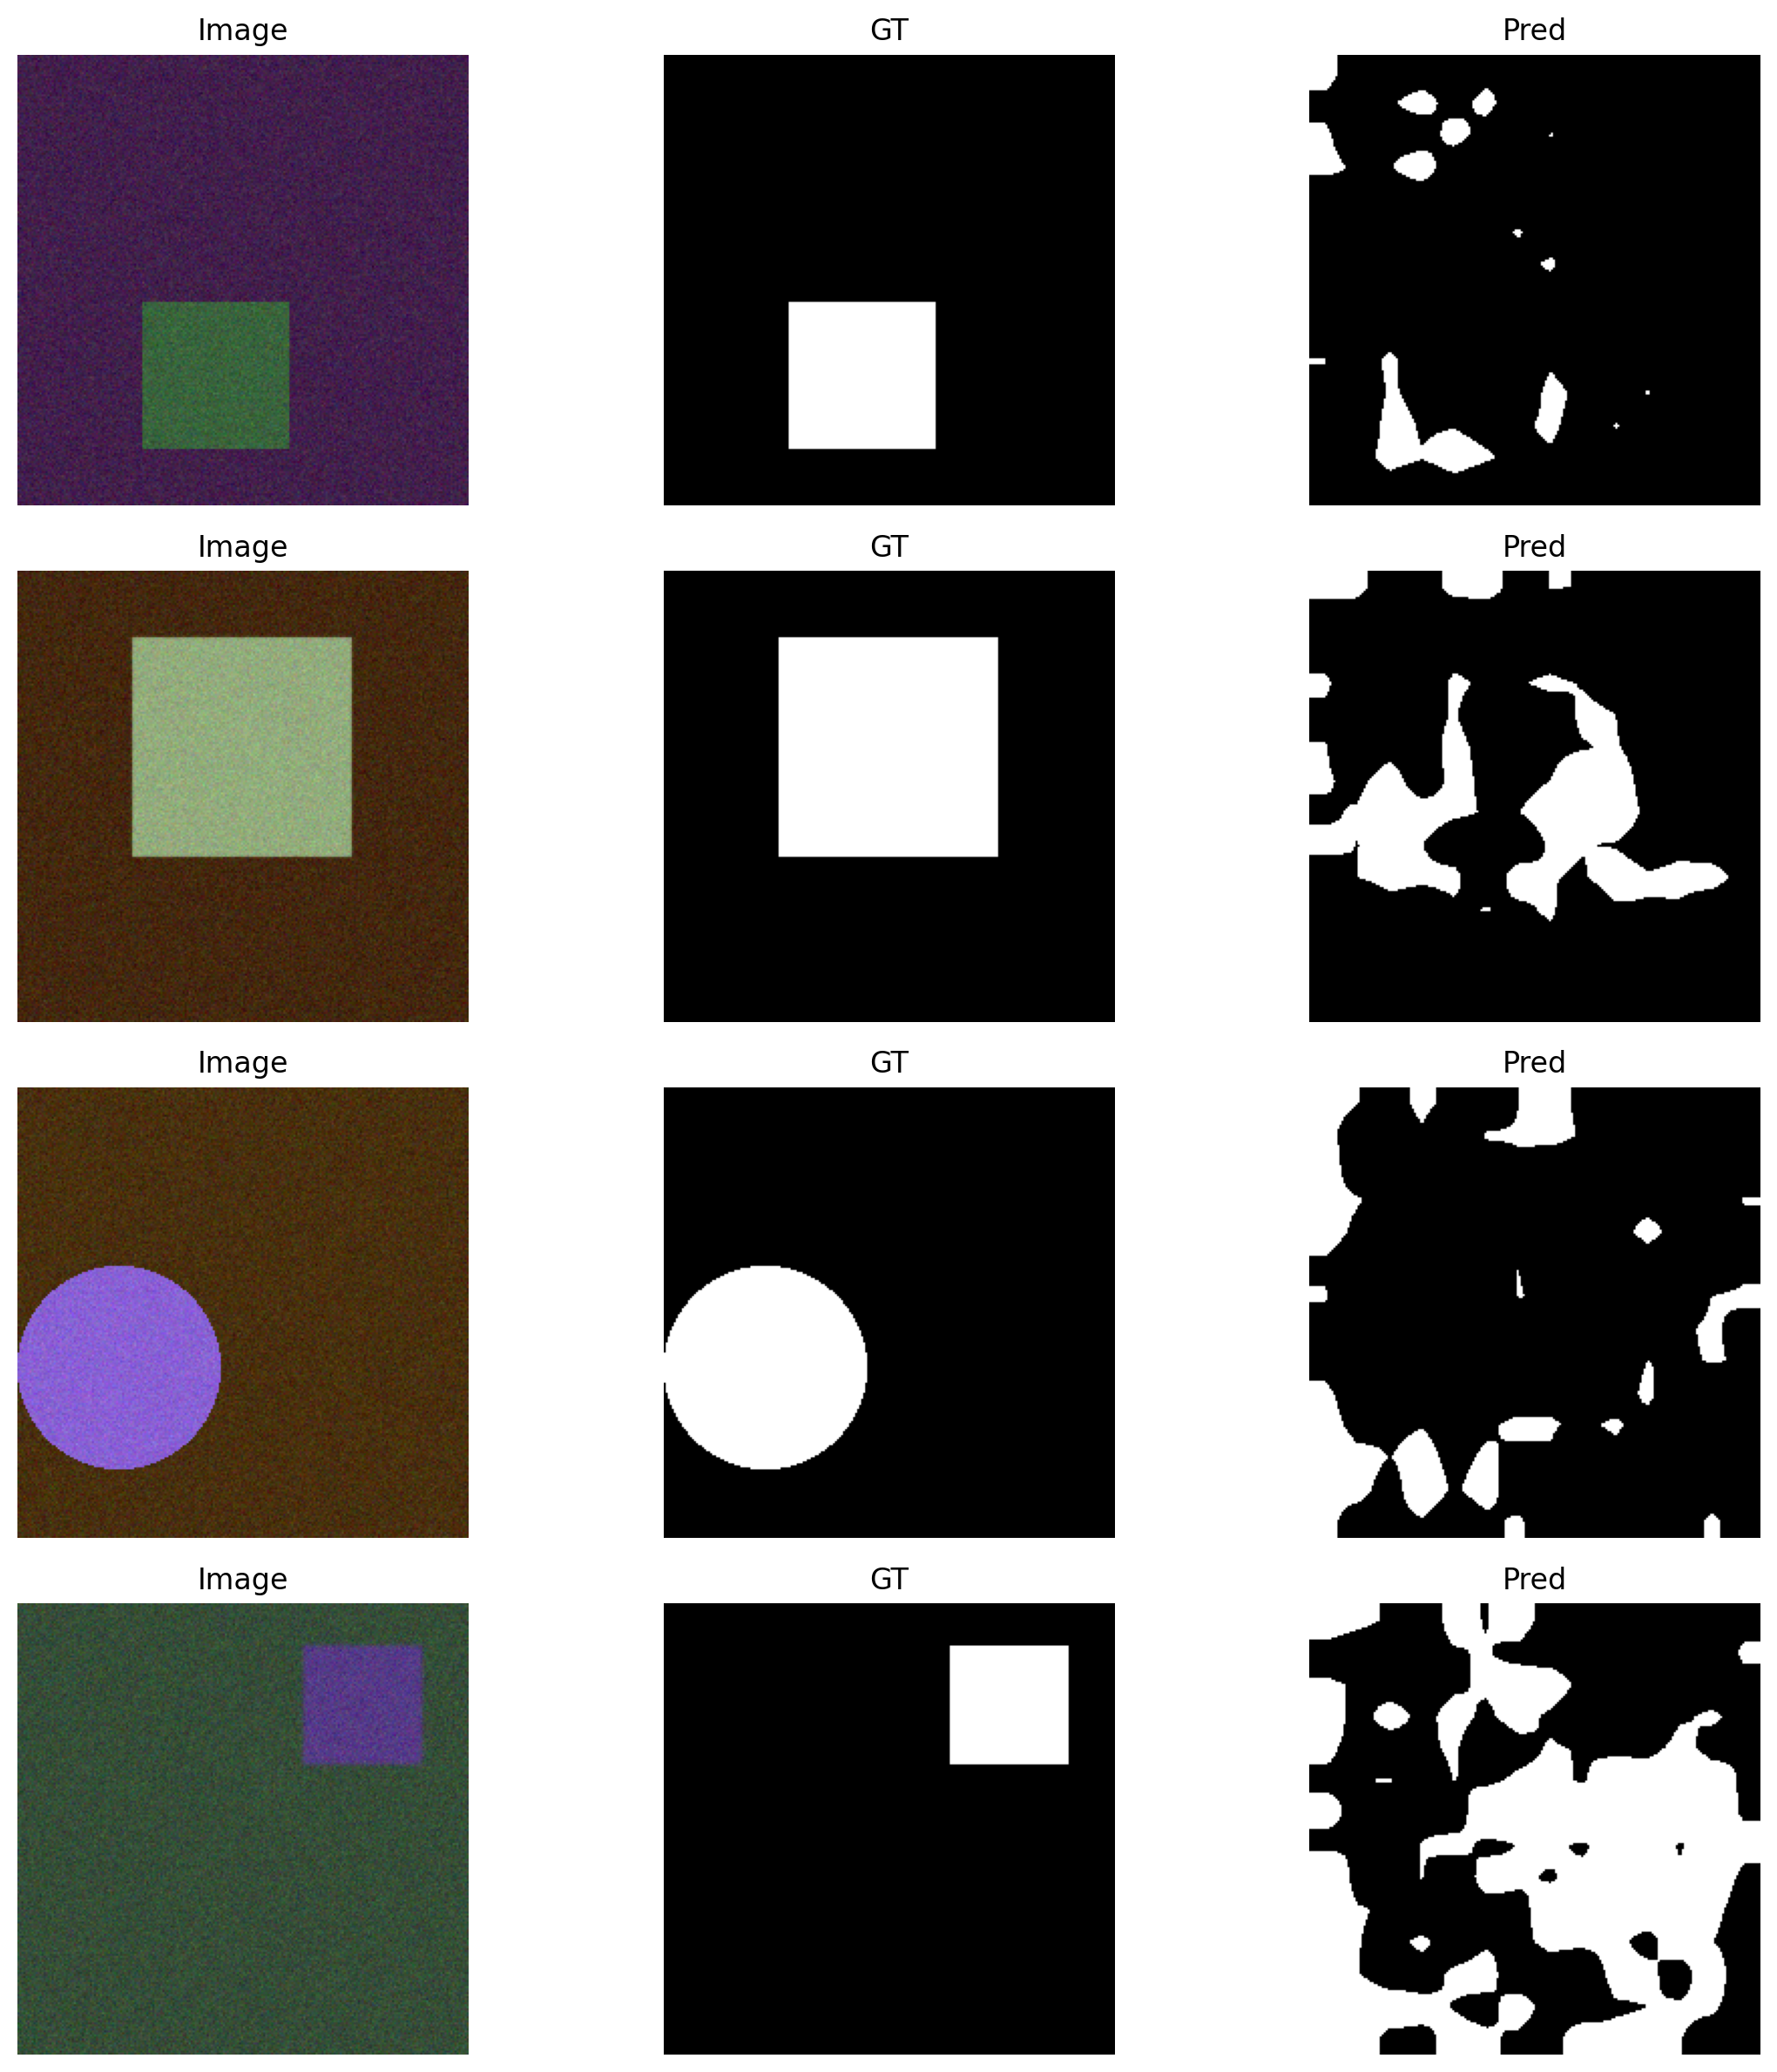

In [47]:
visualize_batch(seg_model, test_loader, device, n=4)

### Training model

In [48]:
criterion = nn.BCEWithLogitsLoss()

# AdamW generally works well with ViTs
optimizer = torch.optim.AdamW(seg_model.parameters(),
                              lr=3e-4,       # a bit higher is fine for small data
                              weight_decay=1e-4)

In [49]:
def train_n_epochs(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10):
    def iou_score(preds, masks):
        preds = (preds > 0.5).float()
        inter = (preds * masks).sum()
        union = ((preds + masks) > 0).float().sum()
        return (inter / (union + 1e-8)).item()

    for epoch in range(1, num_epochs + 1):
        # ---- Train ----
        model.train()
        train_loss = 0.0
        for imgs, masks in train_loader:
            imgs = imgs.to(device)
            masks = masks.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
        train_loss /= len(train_loader.dataset)

        # ---- Eval ----
        model.eval()
        test_loss, inter, union = 0.0, 0.0, 0.0
        with torch.no_grad():
            for imgs, masks in test_loader:
                imgs = imgs.to(device)
                masks = masks.to(device).float().unsqueeze(1)
                logits = model(imgs)
                loss = criterion(logits, masks)
                test_loss += loss.item() * imgs.size(0)

                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).float()
                inter += (preds * masks).sum().item()
                union += ((preds + masks) > 0).float().sum().item()

        test_loss /= len(test_loader.dataset)
        iou = inter / (union + 1e-8)

        print(f"Epoch {epoch:02d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Test Loss: {test_loss:.4f} | "
              f"IoU: {iou:.3f}")

In [50]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [51]:
train_n_epochs(seg_model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10)

Epoch 01/10 | Train Loss: 0.0707 | Test Loss: 0.0212 | IoU: 0.931
Epoch 02/10 | Train Loss: 0.0164 | Test Loss: 0.0136 | IoU: 0.960
Epoch 03/10 | Train Loss: 0.0119 | Test Loss: 0.0112 | IoU: 0.968
Epoch 04/10 | Train Loss: 0.0101 | Test Loss: 0.0099 | IoU: 0.971
Epoch 05/10 | Train Loss: 0.0090 | Test Loss: 0.0093 | IoU: 0.972
Epoch 06/10 | Train Loss: 0.0083 | Test Loss: 0.0084 | IoU: 0.976
Epoch 07/10 | Train Loss: 0.0078 | Test Loss: 0.0083 | IoU: 0.975
Epoch 08/10 | Train Loss: 0.0073 | Test Loss: 0.0076 | IoU: 0.978
Epoch 09/10 | Train Loss: 0.0070 | Test Loss: 0.0074 | IoU: 0.977
Epoch 10/10 | Train Loss: 0.0064 | Test Loss: 0.0069 | IoU: 0.979


Batch image shape: torch.Size([8, 3, 224, 224])
Batch mask shape: torch.Size([8, 224, 224])


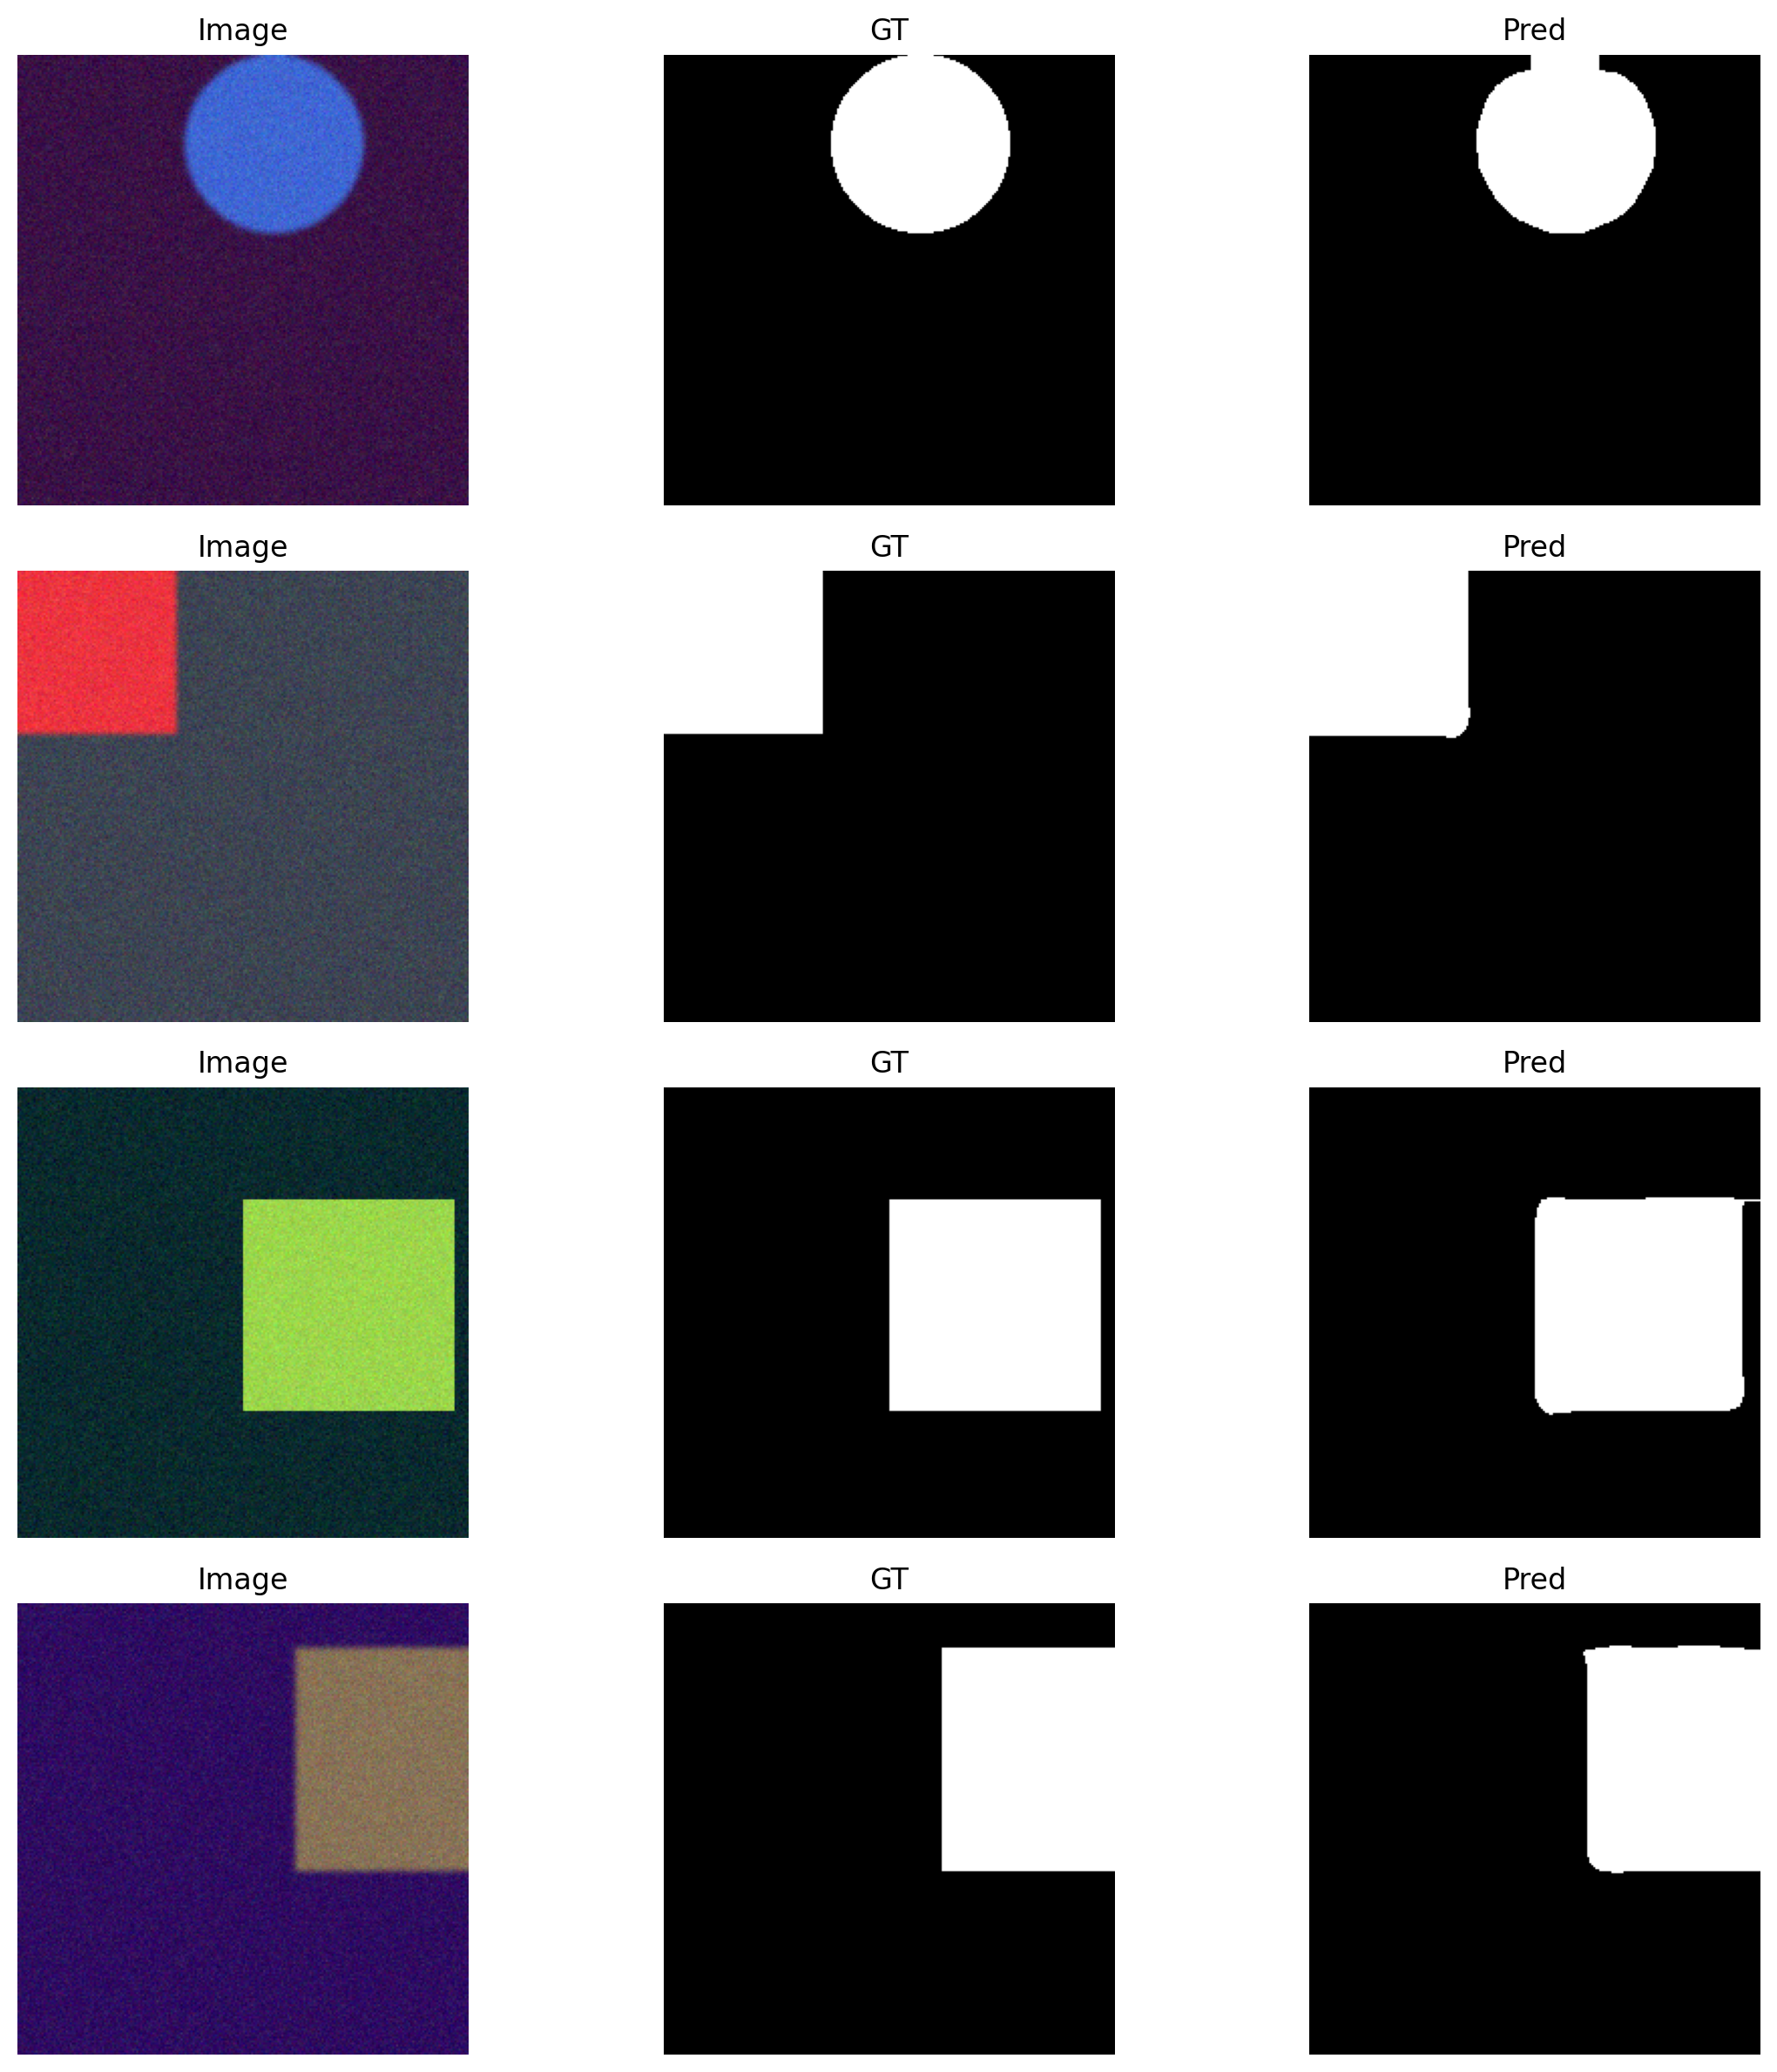

In [52]:
visualize_batch(seg_model, test_loader, device, n=4)